In [1]:
'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
def remove_small_contours(p, thres=10):
    for level in p.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!

            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))

            if diameter<thres: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(

In [3]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi']

In [4]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Set hour min sec to 0. 
init_slice = np.arange(cd - datetime.timedelta(days=35), cd, datetime.timedelta(days=1))

In [5]:
# Forecast times to plot
weeks = pd.to_timedelta(np.arange(0,5,1), unit='W')
months = pd.to_timedelta(np.arange(2,12,1), unit='M')
years = pd.to_timedelta(np.arange(1,2), unit='Y') - np.timedelta64(1, 'D') # need 364 not 365
slices = weeks.union(months).union(years).round('1d')
da_slices = xr.DataArray(slices, dims=('fore_time'))

In [6]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

# Get median ice edge
ds_51 = xr.open_dataset(E.obs['NSIDC_0051']['sipn_nc']+'/NSIDC_0051.nc')
median_ice_fill = esio.get_median_ice_edge(ds_51)
ds_51 = None

In [7]:
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/NSIDC_0081.nc')

In [8]:
# print(ds_51.time.min().values, ds_51.time.max().values)
# print(ds_81.time.min().values, ds_81.time.max().values)
# print(ds_79.time.min().values, ds_79.time.max().values)

In [9]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if x!='piomas'] # remove some models

Starting plots...
2018-03-01T00:00:00.000000
0 days


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


7 days
14 days
21 days
28 days
61 days
91 days
122 days


KeyboardInterrupt: 

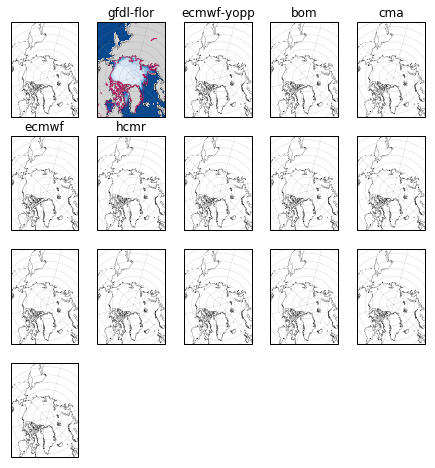

In [10]:
# Get # of models and setup subplot dims
Nmod = len(E.model.keys()) + 1 #(+1 for obs)
Nr = int(np.floor(np.sqrt(Nmod)))
Nc = int(np.ceil(Nmod/Nr))
assert Nc*Nr>=Nmod, 'Need more subplots'

for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "maps")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # Set up plotting info
    if cvar=='sic':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif cvar=='hi':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
    else:
        raise ValueError("cvar not found.")
             
    print("Starting plots...")
    for it in init_slice:
        print(it)
        
        for (cs, ft) in enumerate(da_slices.values): 
            print(ft.astype('timedelta64[D]'))
            cs_str = format(cs, '02')
            
            # New Plot
            (f, axes) = esio.multi_polar_axis(ncols=Nc, nrows=Nr, Nplots=Nmod)
            p = None # initlaize to know if we found any data
            for (i, cmod) in enumerate(models_2_plot):
                i = i+1 # shift for obs
#                 print("Checking model ", cmod, " for data...")
                axes[i].set_title(E.model[cmod]['model_label'])
                
                # Load in Model
                model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')
                
                # Check we have files 
                files = glob.glob(model_forecast)
                if not files:
                    #print("Skipping model", cmod, "no forecast files found.")
                    continue # Skip this model
                ds_model = xr.open_mfdataset(model_forecast)
                ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

                # Set attributes
                ds_model.attrs['model_label'] = E.model[cmod]['model_label']
                ds_model.attrs['model_grid_file'] = E.model[cmod]['grid']
                ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']

                # Select var of interest (if available)
                if cvar in ds_model.variables:
#                     print('found ',cvar)
                    ds_model = ds_model[cvar]
                else:
                    continue
                    
                # Select init and fore_time of interest
                if it in ds_model.init_time.values:
#                     print('found init_time')
                    ds_model = ds_model.sel(init_time=it)
                else:
                    continue
                    
                if ft in ds_model.fore_time.values:
#                     print('found fore_time')
                    ds_model = ds_model.sel(fore_time=ft)
                else:
                    continue
                    
#                 print("Found data for model ", cmod, ". Plotting...")    
                # Average over ensembles (if available)
                ds_model = ds_model.mean(dim='ensemble')
        
                # Plot
                p = ds_model.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
                
                
                # Overlay median ice edge
                cdoy = pd.to_datetime(it + ft).timetuple().tm_yday
                po = median_ice_fill.isel(time=cdoy).plot.contour(ax=axes[i], x='xm', y='ym', 
                                                                  colors=('#bc0f60'),
                                                                  linewidths=[0.5],
                                                                  levels=[0.5], label='Median ice edge 1981-2010')
                remove_small_contours(po, thres=10)
                
                axes[i].set_title(E.model[cmod]['model_label'])

            # Plot Obs (if available)
            if (it + ft) in ds_81.time.values:
                ds_81.sic.sel(time=(it + ft)).plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
            axes[0].set_title('Observed')
            
            
            # Make pretty
            f.subplots_adjust(right=0.8)
            cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
            if p:
                cbar = f.colorbar(p, cax=cbar_ax, label=c_label)
                cbar.set_ticks(np.arange(0,1.1,0.1))
                #cbar.set_ticklabels(np.arange(0,1,0.05))
            
            # Set title of all plots
            init_time =  pd.to_datetime(it).strftime('%Y-%m-%d-%H:%M')
            valid_time = pd.to_datetime(it+ft).strftime('%Y-%m-%d-%H:%M')
            plt.suptitle('Initialization Time: '+init_time+'\n Valid Time: '+valid_time, fontsize=20)
            plt.subplots_adjust(top=0.85)
            
            # Save to file
            f_out = os.path.join(fig_dir,'panArctic_EnsembleMean_'+runType+'_'+init_time+'_'+cs_str+'.png')
            f.savefig(f_out,bbox_inches='tight',dpi=200)
            #print("saved ", f_out)
            
            # Mem clean up
            plt.close(f)
            p = None
